In [257]:
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg, NavigationToolbar2TkAgg
import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns
import os
import sys
import scipy.stats
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from compiler.ast import flatten
from sklearn.neighbors import NearestNeighbors
from itertools import groupby
import math
import networkx as nt
import gc
import psutil
import scipy.stats
import random


In [258]:

def GetBarcode(F):
    B0=list(pd.read_table(F,index_col=0).index)
    return B0
def ReadTable(Infile):return pd.read_table(Infile,sep='\t',index_col=0)

def Mkdir(DirX):
    if not os.path.exists(DirX):
        os.mkdir(DirX)
        
def SaveTable(DF,FileName):
    DF.to_csv(FileName,sep='\t')
        
def Filter(DF,label,List):
    J=DF[list(DF)[0]]>10000000000
    for i in List:
        J=J|(DF[label]==i)
    return DF[J]

def TransDemuxlet(DemuxletFO,DemuxletF,Dict,ColorDict,label):
    DemxDF=pd.read_table(DemuxletFO,sep='\t',index_col=0)
    Index=[i.split('-')[0] for i in DemxDF.index]
    def getSample(x):
        X=x.split('-')
        if X[0]=='SNG':
            return Dict[X[1]]
        else:
            return X[0]
    SampleName=map(getSample,DemxDF['BEST'])
    DemxDFNew=pd.DataFrame({'SampleName':SampleName},index=Index)
    DemxDFNew['SampleColor']=[ColorDict[i] for i in DemxDFNew['SampleName']]
    DemxDFNew.to_csv(DemuxletF,sep='\t')
    DemxDFNew.index=[i+'-'+label for i in list(DemxDFNew.index)]
    return DemxDFNew

def p_adjust_bh(p):
    p = np.asfarray(p)
    by_descend = p.argsort()[::-1]
    by_orig = by_descend.argsort()
    steps = float(len(p)) / np.arange(len(p), 0, -1)
    q = np.minimum(1, np.minimum.accumulate(steps * p[by_descend]))
    return q[by_orig]

def Get_FDR(PSeries):
    return pd.Series(p_adjust_bh(PSeries.values),index=PSeries.index)

def Ttest(A,B,Index_List):
    return pd.Series(scipy.stats.ttest_ind(A,B,axis=1)[1],index=Index_List)
    

# input A/B is DataFrame whose value is after taking log2
def Diff_FDR(A,B,fdc,fdr):
    Indexs=list(set(list(A[(A==0).apply(sum,axis=1)<len(A.columns)].index)+list(B[(B==0).apply(sum,axis=1)<len(B.columns)].index)))
    A2=A.loc[Indexs]
    B2=B.loc[Indexs]
    MeanA=A2.apply(np.mean,axis=1)
    MeanB=B2.apply(np.mean,axis=1)
    FDC=MeanA-MeanB
    Pval=Ttest(A2,B2,Indexs)
    FDR=pd.Series(p_adjust_bh(Pval.values), index=Indexs)
    return FDC,FDR,list(A2[(FDC>fdc)&(FDR<fdr)].index),list(A2[(FDC<-fdc)&(FDR<fdr)].index)
    

def Diff_Pval(A,B,fdc,p):
    Indexs=list(set(list(A[(A==0).apply(sum,axis=1)<len(A.columns)].index)+list(B[(B==0).apply(sum,axis=1)<len(B.columns)].index)))           
    A2=A.loc[Indexs]
    B2=B.loc[Indexs]
    MeanA=A2.apply(np.mean,axis=1)
    MeanB=B2.apply(np.mean,axis=1)
    FDC=MeanA-MeanB
    Pval=Ttest(A2,B2,Indexs)
    return FDC,Pval,list(A2[(FDC>fdc)&(Pval<p)].index),list(A2[(FDC<-fdc)&(Pval<p)].index)
    
    

In [259]:
#
inDir="./scRNA-seq/SourceData/Treg"
outDir="./scRNA-seq/OutPut/Treg"

#MetaDF
MetaData=os.path.join(inDir,"Treg.MetaData.txt")                                                      

#Norm Expression            
DATA=os.path.join(inDir,"Treg.Aggr3.dataNorm.txt")

#SAVER Expression
SAVER=os.path.join(inDir,"Treg.Aggr3.dataSAVER.txt")

#Signature Gene Sets
SigDir="./ATAC-seq/"
Signature=os.path.join(SigDir, "SourceData/SignatureGenes.txt")
Signature_KEGG=os.path.join(SigDir, "SourceData/KEGGSignatureGenes.txt")
Signature_MSig=os.path.join(SigDir, "SourceData/MSigSignatureGenes.txt")

GenomicaEnrichedGeneSets=os.path.join(inDir,"Seurat3.3-100_0.1.gxr.txt")   

#Treg_subsets
TregExpFile=os.path.join(inDir,"count.log.norm.txt")                             




In [352]:
#Read data
MetaDF=ReadTable(MetaData)
ExpSaver=ReadTable(SAVER)
ExpSeurat=ReadTable(DATA)
SignatureDF=ReadTable(Signature)



In [353]:
#Remove low expressed genes
ExpSaver=ExpSaver.T[ExpSaver.apply(np.max,axis=0)>1].T
ExpSeurat=ExpSeurat.T[ExpSeurat.apply(np.max,axis=0)>1].T



In [354]:
ZExpSaver=ExpSaver.apply(scipy.stats.zscore,axis=0)
ZExpSeurat=ExpSeurat.apply(scipy.stats.zscore,axis=0)


In [372]:
#ColorDict
BachColorsDict={'Norm':'darkblue','SLE1':'coral','SLE2':'firebrick'}
ClusterColorDict={6: '#4D8A9C', 14: '#DE9B53'}       #Cluster 6 is Treg1 , Cluster 14 is Treg2
StateColorDict={'N':'darkblue','S':'firebrick'}
MetaDF['State2_Color']=[StateColorDict[i] for i in MetaDF['State2']]

MetaDF['Celltype_Color']=[ClusterColorDict[i] for i in MetaDF['Cluster']]


In [373]:
P14Cells=list(MetaDF[(MetaDF['Cluster']==14)&(MetaDF['State2']=='S')].index)
N14Cells=list(MetaDF[(MetaDF['Cluster']==14)&(MetaDF['State2']=='N')].index)
P6Cells=list(MetaDF[(MetaDF['Cluster']==6)&(MetaDF['State2']=='S')].index)
N6Cells=list(MetaDF[(MetaDF['Cluster']==6)&(MetaDF['State2']=='N')].index)

Treg14Cells=list(MetaDF[(MetaDF['Cluster']==14)].index)
Treg6Cells=list(MetaDF[(MetaDF['Cluster']==6)].index)

random.shuffle(P14Cells)
random.shuffle(N14Cells)
random.shuffle(P6Cells)
random.shuffle(N6Cells)
random.shuffle(Treg14Cells)
random.shuffle(Treg6Cells)



# Cluster Scatter Plot

In [54]:
Dir=os.path.join(outDir,'Treg_Cluster')
Mkdir(Dir)


In [55]:
def Scatter(ScatterDF,label,Dir,X='tSNE_1_All',Y='tSNE_2_All',hue=None,hueColorDict=None,sub='AllCells',legend=True,vmin=-1,vmax=1):
    outfig=os.path.join(Dir,label+'.Scatter.pdf')
    plt.style.use('seaborn-white')
    fig=plt.figure(figsize=(8,8))
    ax=fig.add_axes([0.15,0.15,0.8,0.8])
    if type(hueColorDict)==str:
        sns.scatterplot(x=X,y=Y,data=ScatterDF,hue=hue,palette=hueColorDict,s=25,ax=ax,edgecolor='none',hue_norm=(vmin,vmax),alpha=0.6)
        ax.legend(fontsize='xx-large',markerscale=1.5,ncol=1,edgecolor='k',columnspacing=0.1,labelspacing=0.2,handletextpad=0.1)
    elif type(hueColorDict)==dict:
        for h in hueColorDict:
            c=hueColorDict[h]
            DFsub=ScatterDF[ScatterDF[hue]==h]
            ax.scatter(DFsub[X],DFsub[Y],c=c,s=15,label=h,alpha=0.6)
        if legend:
            ax.legend(fontsize='xx-large',markerscale=8,ncol=3,edgecolor='k',columnspacing=0,labelspacing=0,handletextpad=0)
    ax.set_title(sub+'-'+hue,fontsize=20)
    ax.tick_params(axis='x',labelsize=20)
    ax.tick_params(axis='y',labelsize=20)
    ax.set_xlabel(X,fontsize=25)
    ax.set_ylabel(Y,fontsize=25)
    ax.set_ylim([-15,20])
    ax.set_xlim([5,35])
    fig.savefig(outfig,dpi=500)
    plt.show()
    


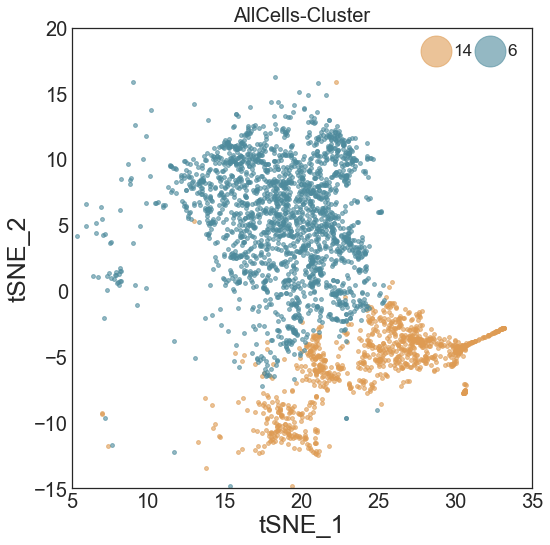

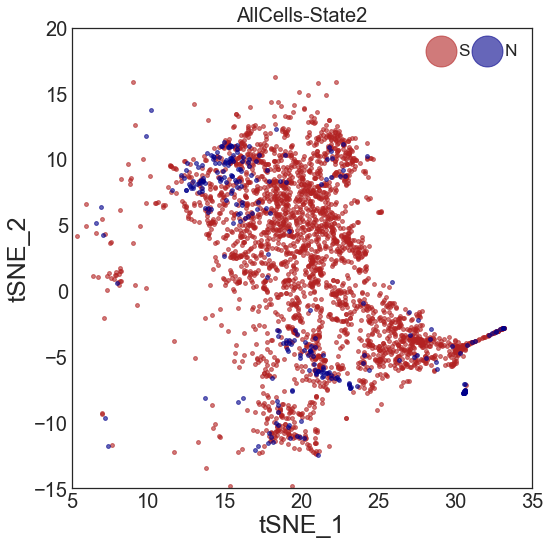

In [59]:
Scatter(MetaDF,'Treg.Cluster',Dir,X='tSNE_1',Y='tSNE_2',hue='Cluster',hueColorDict=ClusterColorDict,sub='AllCells',legend=True,vmin=-1,vmax=1)         
Scatter(MetaDF,'Treg.ClinicalState',Dir,X='tSNE_1',Y='tSNE_2',hue='State2',hueColorDict=StateColorDict,sub='AllCells',legend=True,vmin=-1,vmax=1)         




# Treg1-Treg2 Differential Genes

In [362]:
Dir=os.path.join(outDir, 'Treg_DifferentialGenes')
Mkdir(Dir)


In [363]:
def DiffGene(A,B,mr,Dir,label):
    mA=A.apply(np.mean,axis=1)
    mB=B.apply(np.mean,axis=1)
    DiffDF=pd.DataFrame({},index=A.index)
    P=[]
    DiffDF['FOLD']=mA-mB
    for g in A.index:
        try:
            _,p=scipy.stats.mannwhitneyu(list(A.loc[g]),list(B.loc[g]))
        except ValueError:
            p=1
        P.append(p)
    DiffDF['pvalue']=P
    DiffDF['FDR']=p_adjust_bh(P)
    
    P=pd.Series(P,index=A.index)
    Q_Val=pd.Series(p_adjust_bh(P),index=A.index)
    
    Result=pd.DataFrame({},index=A[((mA-mB)>mr)&(P<0.01)&(Q_Val<0.05)].index)
    Result['Diff']=(mA-mB)[Result.index]
    Result.to_csv(os.path.join(Dir,label+'_Diff_'+str(mr)+'_p_0.01.VarGene.txt'),sep='\t',header=False)
    return Result,DiffDF

def VolcanoPlot(Dif,Dir,Label,R,ACmap='Reds',BCmap='Blues',List=None):
    Dif1=Dif[((Dif['FOLD']>-R)&(Dif['FOLD']<1))|(Dif['pvalue']<1.30001)]  #灰色的
    Dif2= Dif[(Dif['FOLD']>R)&(Dif['pvalue']>1.3)]                                                   #蓝色的
    Dif3= Dif[(Dif['FOLD']<-R)&(Dif['pvalue']>1.3)]                                                      #红色的
    plt.style.use('seaborn-white')
    fig=plt.figure(figsize=(6,4.5))
    ax=fig.add_axes([0.2,0.2,0.7,0.7])
    ax.tick_params(axis='y',length=7,labelsize=15,direction='out')
    ax.tick_params(axis='x',length=7,labelsize=15,direction='out')
    ax.set_ylabel('-log10 P-value',fontsize=15)
    ax.set_xlabel('log2 mean FoldChange',fontsize=15)
#    ax.set_xlim([-0.5,0.5])
#    ax.set_ylim([0,350])
    
    ax.scatter(Dif1['FOLD'],Dif1['pvalue'],c='darkgray',alpha=0.2,s=4,edgecolor='none')
    ax.scatter(Dif2['FOLD'],Dif2['pvalue'],c=Dif2['FDR'],cmap=ACmap,alpha=0.8,s=4,edgecolor='none',vmin=0.3, vmax=2)         
    ax.scatter(Dif3['FOLD'],Dif3['pvalue'],c=Dif3['FDR'],cmap=BCmap,alpha=0.8,s=4,edgecolor='none',vmin=0.3, vmax=2)               
    for g in list(Dif.index):
        if g in List:
            if (Dif['FOLD'][g]<10000) and (Dif['pvalue'][g]<10000):
                ax.text(Dif['FOLD'][g],Dif['pvalue'][g],g,fontsize=3)
    ax.axhline(y=2,ls='--',color='darkgray',alpha=0.6,lw=1)
    ax.axvline(x=-R,ls='--',color='darkgray',alpha=0.6,lw=1)
    ax.axvline(x=R,ls='--',color='darkgray',alpha=0.6,lw=1)
    fig.savefig(os.path.join(Dir,Label+'_Volcanoplot.pdf'))
    plt.show()
    return 
    

In [364]:
ZDiff_14_6_SAVER,_=DiffGene(ZExpSaver.loc[Treg14Cells].T,ZExpSaver.loc[Treg6Cells].T,0.4,Dir,'14-6-14High.SAVER.R_0.4')               
ZDiff_6_14_SAVER,ZDiffDF_6_14_SAVER=DiffGene(ZExpSaver.loc[Treg6Cells].T,ZExpSaver.loc[Treg14Cells].T,0.4,Dir,'6-14-6High.SAVER.R_0.4')               


ZDiff6_N_P_SAVER,_=DiffGene(ZExpSaver.loc[N6Cells].T,ZExpSaver.loc[P6Cells].T,0.4,Dir,'Cluster6-NP-NHigh.SAVER.R_0.4')               
ZDiff6_P_N_SAVER,ZDiffDF_6_PN_SAVER=DiffGene(ZExpSaver.loc[P6Cells].T,ZExpSaver.loc[N6Cells].T,0.4,Dir,'Cluster6-NP-PHigh.SAVER.R_0.4')               

ZDiff14_N_P_SAVER,_=DiffGene(ZExpSaver.loc[N14Cells].T,ZExpSaver.loc[P14Cells].T,0.4,Dir,'Cluster14-NP-NHigh.SAVER.R_0.4')               
ZDiff14_P_N_SAVER,ZDiffDF_14_PN_SAVER=DiffGene(ZExpSaver.loc[P14Cells].T,ZExpSaver.loc[N14Cells].T,0.4,Dir,'Cluster14-NP-PHigh.SAVER.R_0.4')               


#######################################Seurat Zscore Diff
ZDiff_14_6_Seurat,_=DiffGene(ZExpSeurat.loc[Treg14Cells].T,ZExpSeurat.loc[Treg6Cells].T,0.4,Dir,'14-6-14High.Seurat.R_0.4')               
ZDiff_6_14_Seurat,ZDiffDF_6_14_Seurat=DiffGene(ZExpSeurat.loc[Treg6Cells].T,ZExpSeurat.loc[Treg14Cells].T,0.4,Dir,'6-14-6High.Seurat.R_0.4')               

ZDiff6_N_P_Seurat,_=DiffGene(ZExpSeurat.loc[N6Cells].T,ZExpSeurat.loc[P6Cells].T,0.4,Dir,'Cluster6-NP-NHigh.Seurat.R_0.4')               
ZDiff6_P_N_Seurat,ZDiffDF_6_PN_Seurat=DiffGene(ZExpSeurat.loc[P6Cells].T,ZExpSeurat.loc[N6Cells].T,0.4,Dir,'Cluster6-NP-PHigh.Seurat.R_0.4')               

ZDiff14_N_P_Seurat,_=DiffGene(ZExpSeurat.loc[N14Cells].T,ZExpSeurat.loc[P14Cells].T,0.4,Dir,'Cluster14-NP-NHigh.Seurat.R_0.4')               
ZDiff14_P_N_Seurat,ZDiffDF_14_PN_Seurat=DiffGene(ZExpSeurat.loc[P14Cells].T,ZExpSeurat.loc[N14Cells].T,0.4,Dir,'Cluster14-NP-PHigh.Seurat.R_0.4')               




In [ ]:
#Treg1 和 Treg2 差异基因

AllTregCells_Order=Treg6Cells+Treg14Cells

DiffGeneTregExpSAVER_Zscore=ZExpSaver.loc[AllTregCells_Order][list(ZDiff_14_6_SAVER.index)+list(ZDiff_6_14_SAVER.index)]                  



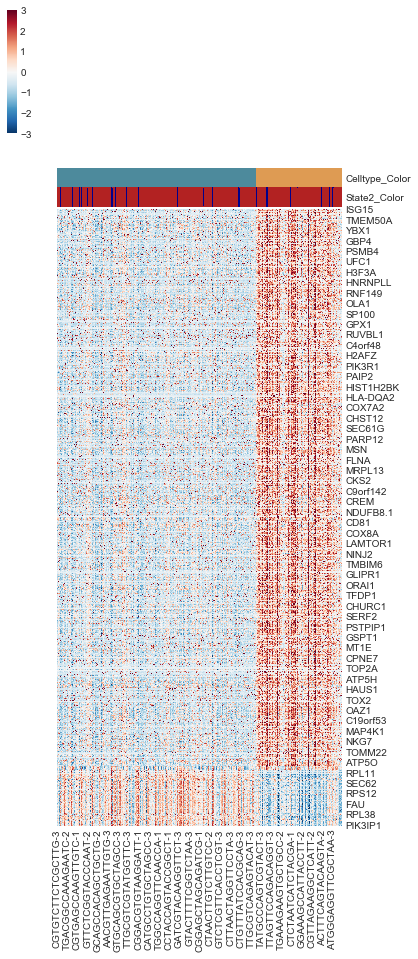

In [159]:
fig=sns.clustermap(DiffGeneTregExpSAVER_Zscore.T,figsize=(6,15),col_cluster=False,row_cluster=False,cmap='RdBu_r',method='average',metric='correlation',vmax=3,vmin=-3,col_colors=MetaDF.loc[AllTregCells_Order][['Celltype_Color','State2_Color']])              
plt.show()
fig.savefig(os.path.join(Dir,'SAVER_Treg1_Treg2_DiffGenes.UTest_0.01_R_0.4.Cluster.Order.pdf'))
SaveTable(DiffGeneTregExpSAVER_Zscore.T,os.path.join(Dir,'SAVER_Treg1_Treg2_DiffGenes.UTest_0.01_R_0.4.Cluster.Order.txt'))





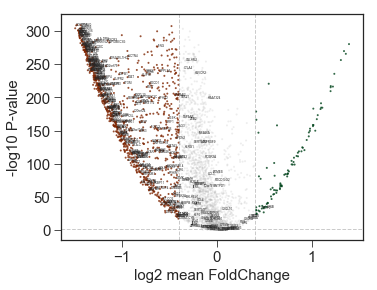

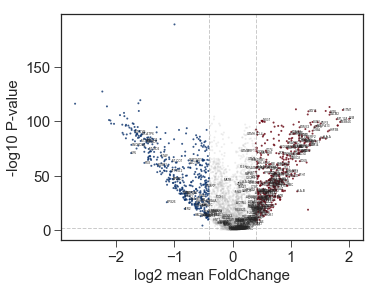

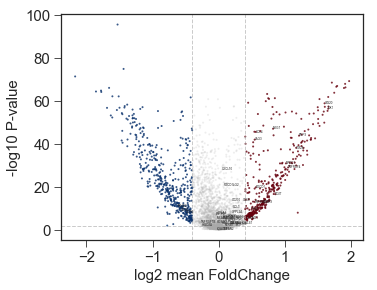

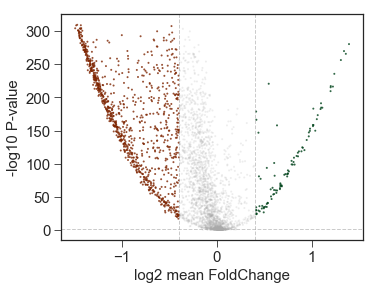

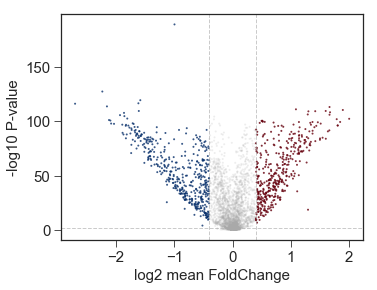

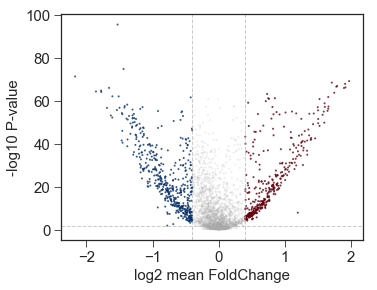

In [336]:
#VolcanoPlot Saver
ExList=list(set(list(SignatureDF['Treg Exhaustion'].dropna())+list(SignatureDF['T cell Exhaustion'].dropna())+['TIGIT']))  #+list(Signature['Type I Interferon response'].dropna())                   
ThList=list(set(list(SignatureDF['Th1_Signature'].dropna())+list(SignatureDF['Th2_Signature'].dropna())+list(SignatureDF['Th17_Signature'].dropna())+list(SignatureDF['TEMRA_Signature'].dropna())))


VolcanoPlot(ZDiffDF_6_14_SAVER,Dir,'Saver_DiffDF_6_14',0.4,ACmap='Greens',BCmap='Oranges',List=ExList+ThList)
VolcanoPlot(ZDiffDF_6_PN_SAVER,Dir,'Saver_DiffDF_6_PN',0.4,List=ThList)
VolcanoPlot(ZDiffDF_14_PN_SAVER,Dir,'Saver_DiffDF_14_PN',0.4,List=ExList)

VolcanoPlot(ZDiffDF_6_14_SAVER,Dir,'Saver_DiffDF_6_14_WithoutLabel',0.4,ACmap='Greens',BCmap='Oranges',List=[])
VolcanoPlot(ZDiffDF_6_PN_SAVER,Dir,'Saver_DiffDF_6_PN_WithoutLabel',0.4,List=[])
VolcanoPlot(ZDiffDF_14_PN_SAVER,Dir,'Saver_DiffDF_14_PN_WithoutLabel',0.4,List=[])



## Violinplot

In [153]:


def ViolinPlot(DF,label, x,y,hue='State',hueDict={'N':'darkblue','P':'firebrick'}):
    Title=''
    for i in list(set(DF[x])):
        df=DF[DF[x]==i]
        A=df[df[hue]==list(ClusterColorDict)[0]][y]
        B=df[df[hue]==list(ClusterColorDict)[1]][y]
        Title=Title+str(i)+':'+str(scipy.stats.mannwhitneyu(A.values,B.values)[1])+'_'
    
    fig=plt.figure(figsize=(3,3))
    #ax=fig.add_axes([10.0/(10+0.45*len(list(DF))),0.2,0.95-10.0/(10+0.45*len(list(DF))),0.7])
    ax=fig.add_axes([0.2,0.2,0.8,0.7])
    sns.violinplot(x=x, y=y, hue=hue,data=DF, palette=hueDict,split=False,  inner=None,ax=ax) 
    ax.set_title(Title)
    #ax.set_ylim(-0.1,1.1)
    plt.savefig(os.path.join(Dir, label+'.pdf'))
    plt.show()
    
    

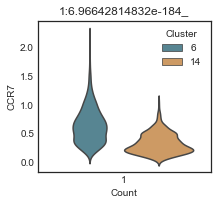

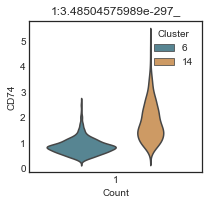

In [112]:
gene='CCR7'
MetaDF[gene]=ExpSaver.loc[MetaDF.index][gene]
ViolinPlot(MetaDF,'Cluster'+'_'+gene, 'Count',gene,hue='Cluster',hueDict=ClusterColorDict)

gene='CD74'
MetaDF[gene]=ExpSaver.loc[MetaDF.index][gene]
ViolinPlot(MetaDF,'Cluster'+'_'+gene, 'Count',gene,hue='Cluster',hueDict=ClusterColorDict)


# SLE Treg Exhaustion Genes 

In [169]:

Patients_TregSpecificGenes_Saver=[i for i in list(ZDiff14_P_N_SAVER.index) if (i not in list(SignatureDF['Type I Interferon response'].dropna())) and (i not in list(SignatureDF['Type II Interferon Response'].dropna())) and ('IFI' not in i) and ('ISG' not in i)]                                                



In [175]:
for i in Patients_TregSpecificGenes_Saver:
    print i


TNFRSF18
TNFRSF4
AURKAIP1
ENO1
FBXO6
SRRM1
TMEM50A
CD52
ATPIF1
PTP4A2
PSMB2
ATP6V0B
PRDX1
SCP2
TMEM59
GNG5
GBP1
GBP4
PSMA5
LAMTOR5
CAPZA1
CTSS
S100A11
S100A6
S100A4
KRTCAP2
SH2D2A
SELL
PTPRC
IKBKE
SRP9
GUK1
HNRNPU
CMPK2
RSAD2
AC092580.4
ID2
YWHAQ
PDIA6
EIF2AK2
CALM2
PLEK
SNRPG
TMSB10
VAMP8
DUSP2
COX5B
MIR4435-1HG
ACTR3
DBI
NMI
HNRNPA3
HSPE1
AC011997.1
SPATS2L
CFLAR
SUMO1
SP110
SP100
PTMA
PDCD1
BHLHE40
SPCS1
ARL6IP5
CLDND1
CD47
TRAT1
TIGIT
PARP9
PARP14
H1FX
PLSCR1
SELT
GPR171
TNFSF10
CCDC50
C4orf48
TMEM156
OCIAD2
HERC6
HERC5
PYURF
H2AFZ
UBE2D3
C4orf3
DDX60
DDX60L
SUB1
GZMA
GPBP1
ERAP2
C5orf56
SKP1
CD74
ATP6V0E1
PRELID1
TMED9
HIST1H1C
LTB
TAP2.1
PSMB8
PSMB9
TAP1
TAPBP
ETV7
PIM1
COX7A2
SNX3
CD164
SAMD3
RNASET2
PSMB1
CHST12
ACTB
ICA1
NDUFA4
NT5C3A
PSMA2.1
SEC61G
SRI
SAMD9
SAMD9L
SHFM1
BUD31
ATP5J2
LAMTOR4
CAPZA2
ATP6V1F
PARP12
NDUFB2
GSTK1
GIMAP7
GIMAP4
GIMAP5
TMSB4X
SAT1
PIM2
IL2RG
CXCR3
XIST
ITM2A
NGFRAP1
NDUFA1
BCAP31
LY96
FABP5
COX6C
MYC
GSDMD
CHMP5
GADD45G
NINJ1
TXN
STOM
ARPC5L
PHPT1


In [177]:
for i in ZDiff14_P_N_SAVER.index:
    print i

ISG15
TNFRSF18
TNFRSF4
AURKAIP1
ENO1
FBXO6
SRRM1
TMEM50A
CD52
IFI6
ATPIF1
PTP4A2
PSMB2
ATP6V0B
PRDX1
SCP2
TMEM59
IFI44L
IFI44
GNG5
GBP1
GBP4
PSMA5
LAMTOR5
CAPZA1
CTSS
S100A11
S100A6
S100A4
KRTCAP2
SH2D2A
IFI16
SELL
PTPRC
IKBKE
SRP9
GUK1
HNRNPU
CMPK2
RSAD2
AC092580.4
ID2
YWHAQ
PDIA6
EIF2AK2
CALM2
PLEK
SNRPG
TMSB10
VAMP8
DUSP2
COX5B
MIR4435-1HG
ACTR3
DBI
NMI
HNRNPA3
STAT1
HSPE1
AC011997.1
SPATS2L
CFLAR
SUMO1
SP110
SP100
PTMA
PDCD1
BHLHE40
TREX1
SPCS1
ARL6IP5
CLDND1
CD47
TRAT1
TIGIT
PARP9
PARP14
H1FX
PLSCR1
SELT
GPR171
TNFSF10
CCDC50
C4orf48
TMEM156
OCIAD2
HERC6
HERC5
PYURF
H2AFZ
UBE2D3
C4orf3
DDX60
DDX60L
SUB1
GZMA
GPBP1
ERAP2
C5orf56
SKP1
CD74
ATP6V0E1
PRELID1
TMED9
HIST1H1C
HLA-A
HLA-C
HLA-B
LTB
HLA-DRA
HLA-DRB5
HLA-DRB1
TAP2.1
PSMB8
PSMB9
TAP1
HLA-DPA1
HLA-DPB1
TAPBP
ETV7
PIM1
COX7A2
SNX3
CD164
SAMD3
RNASET2
PSMB1
CHST12
ACTB
ICA1
NDUFA4
NT5C3A
PSMA2.1
SEC61G
SRI
SAMD9
SAMD9L
SHFM1
BUD31
ATP5J2
LAMTOR4
CAPZA2
ATP6V1F
PARP12
NDUFB2
GSTK1
GIMAP7
GIMAP4
GIMAP5
TMSB4X
SAT1
PIM2
IL2RG
CXCR

# Gene Expression Circular Plot

In [182]:
Dir=os.path.join(outDir,'Treg_Gene_Expression')
Mkdir(Dir)


In [193]:
def CircularPlot(DF,SizeDF,FileLabel,Dir,vmin=0,vmax=2.5,sizevmax=0.5,sizeWeight=300,cmap='pink_r'):
    SizeDF[SizeDF>sizevmax]=sizevmax
    plt.style.use('seaborn-white')
    fig=plt.figure(figsize=(0.45*len(list(DF)),0.38*len(DF)))
    #ax=fig.add_axes([10.0/(10+0.45*len(list(DF))),0.2,0.95-10.0/(10+0.45*len(list(DF))),0.7])
    ax=fig.add_axes([0.2,0.2,0.8,0.7])
    X=range(1,len(list(DF))+1)*len(DF)
    Y=sorted(range(1,len(DF)+1)*len(list(DF)))
    Color=[]
    Size=[]
    for i in DF.index:
        Color=Color+list(DF.loc[i])
        Size=Size+list(SizeDF.loc[i])
    Size=sizeWeight*np.array(Size)
    ax.scatter(X,Y,c=Color,cmap=cmap,s=Size,edgecolors='none',linewidths=0,vmin=vmin,vmax=vmax)
    ax.set_xlim([0.5,len(list(DF))+0.5])
    ax.set_ylim([0.6,len(DF)+0.6])
    ax.set_xticks(range(1,len(list(DF))+1))
    ax.set_yticks(range(1,len(DF)+1))
    ax.set_xticklabels(list(DF),rotation='vertical')
    ax.set_yticklabels(list(DF.index))
    ax.tick_params(axis='y',length=5,labelsize=15,direction='out')
    ax.tick_params(axis='x',length=5,labelsize=15,direction='out')
    ax.set_title('Size:{}-{},color:{}-{}'.format(str(min(SizeDF.apply(min))),str(max(SizeDF.apply(max))),str(vmin),str(vmax)))            
    fig.savefig(os.path.join(Dir,FileLabel+'.ScatterPlot.pdf'))
    plt.show()
    
    SaveTable(DF,os.path.join(Dir,FileLabel+'.ScatterPlot.Color.txt'))
    SaveTable(SizeDF,os.path.join(Dir,FileLabel+'.ScatterPlot.Size.txt'))

    
def GetDF_ColorSizeDF(Exp,r,Category,CategoryLabel):
    DF=pd.DataFrame({},index=Exp.columns)
    for i in range(len(Category)):
        DF[CategoryLabel[i]]=Exp.loc[Category[i]].dropna().apply(np.mean,axis=0)
    SizeDF=pd.DataFrame({},index=Exp.columns)
    def GetRatio(L,r):
        return [sum([1 for i in L[g] if i>r])/float(len(L)) for g in list(L)]
    for i in range(len(Category)):
        SizeDF[CategoryLabel[i]]=GetRatio(Exp.loc[Category[i]].dropna(),r)
    return DF,SizeDF


In [188]:
ColorDF,SizeDF=GetDF_ColorSizeDF(ExpSaver,0.05,[P14Cells,N14Cells,P6Cells,N6Cells],['P14','N14','P6','N6'])
ZColorDF,ZSizeDF=GetDF_ColorSizeDF(ZExpSaver,0,[P14Cells,N14Cells,P6Cells,N6Cells],['P14','N14','P6','N6'])
AllGenes=list(ColorDF.index)


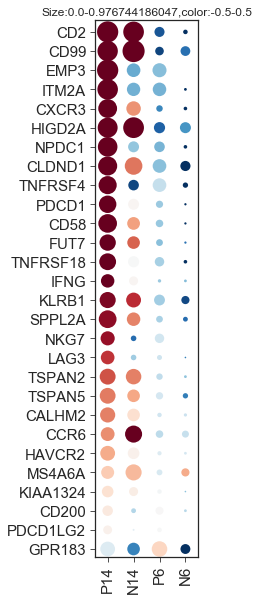

In [194]:
ExhaustionGenes=[i for i in list(SignatureDF['Treg Exhaustion'].dropna()) if i in AllGenes]

Color=ZColorDF.loc[ExhaustionGenes].sort_values('P14')
Size=ZSizeDF.loc[Color.index]
CircularPlot(Color,Size,'TregExhaustionGenes.Expression.Saver.Zscore',Dir,vmin=-0.5,vmax=0.5,sizevmax=1,sizeWeight=500,cmap='RdBu_r')                                   



# Signature Genes for nTreg,eTreg,FrIII

In [217]:

Dir=os.path.join(outDir,'Treg_subtypes')
Mkdir(Dir)

fdc=1.5
fdr=0.5
Dir=os.path.join(Dir,'fdc_'+str(fdc)+'_fdr'+str(fdr))
Mkdir(Dir)


In [218]:
TregExpDF=ReadTable(TregExpFile)

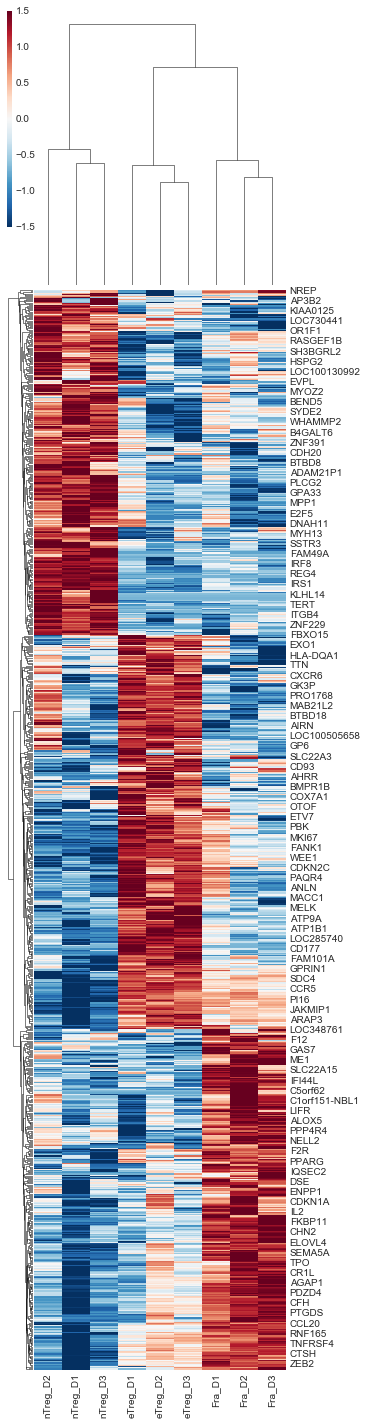

In [221]:
# take log2
TregExpDF=TregExpDF[TregExpDF.apply(max,axis=1)>1]
ZTregExpDF=TregExpDF.apply(scipy.stats.zscore,axis=1)


FraDF=TregExpDF[[i for i in TregExpDF.columns if 'Fra' in i]]
eTregDF=TregExpDF[[i for i in TregExpDF.columns if 'eTreg' in i]]
nTregDF=TregExpDF[[i for i in TregExpDF.columns if 'nTreg' in i]]

_,_,a,b=Diff_FDR(FraDF,pd.concat([eTregDF,nTregDF],axis=1),fdc,fdr)           
_,_,c,d=Diff_FDR(nTregDF,pd.concat([eTregDF,FraDF],axis=1),fdc,fdr)           
_,_,e,f=Diff_FDR(eTregDF,pd.concat([FraDF,nTregDF],axis=1),fdc,fdr)  
AllSignatureGenes=list(set(a+c+e))

subGeneExpDF=TregExpDF.loc[AllSignatureGenes]
ZsubGeneExpDF=subGeneExpDF.apply(scipy.stats.zscore,axis=1)
SaveTable(ZsubGeneExpDF,os.path.join(Dir,'SignatureGenes.txt'))
fig=sns.clustermap(ZsubGeneExpDF,figsize=(5,25),cmap='RdBu_r',vmax=1.5,vmin=-1.5)
plt.show()
fig.savefig(os.path.join(Dir,'SignaturesGene_Expression.pdf'))

FraTregFoldChangeDF=FraDF.loc[AllSignatureGenes].apply(np.mean,axis=1)-(eTregDF.loc[AllSignatureGenes].apply(np.mean,axis=1)+nTregDF.loc[AllSignatureGenes].apply(np.mean,axis=1))/2.0                              
eTregFoldChangeDF=eTregDF.loc[AllSignatureGenes].apply(np.mean,axis=1)-(FraDF.loc[AllSignatureGenes].apply(np.mean,axis=1)+nTregDF.loc[AllSignatureGenes].apply(np.mean,axis=1))/2.0                              
nTregFoldChangeDF=nTregDF.loc[AllSignatureGenes].apply(np.mean,axis=1)-(FraDF.loc[AllSignatureGenes].apply(np.mean,axis=1)+eTregDF.loc[AllSignatureGenes].apply(np.mean,axis=1))/2.0                              

FraTregSignature=list(FraTregFoldChangeDF[FraTregFoldChangeDF.sort_values()>1.5].index)
eTregSignature=list(eTregFoldChangeDF[eTregFoldChangeDF.sort_values()>1.5].index)
nTregSignature=list(nTregFoldChangeDF[nTregFoldChangeDF.sort_values()>1.5].index)

SignatureDF['FraTreg']=FraTregSignature+[np.nan]*(1000-len(FraTregSignature))
SignatureDF['eTreg']=eTregSignature+[np.nan]*(1000-len(eTregSignature))
SignatureDF['nTreg']=nTregSignature+[np.nan]*(1000-len(nTregSignature))


In [239]:
ExpSaver=ReadTable(SAVER)
ExpSeurat=ReadTable(DATA)


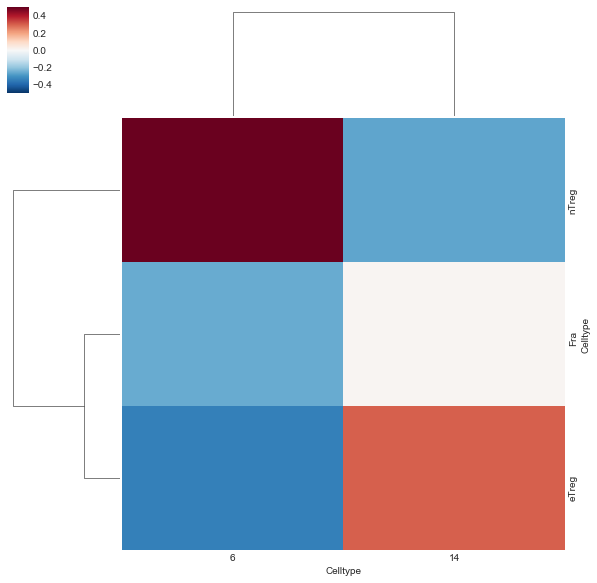

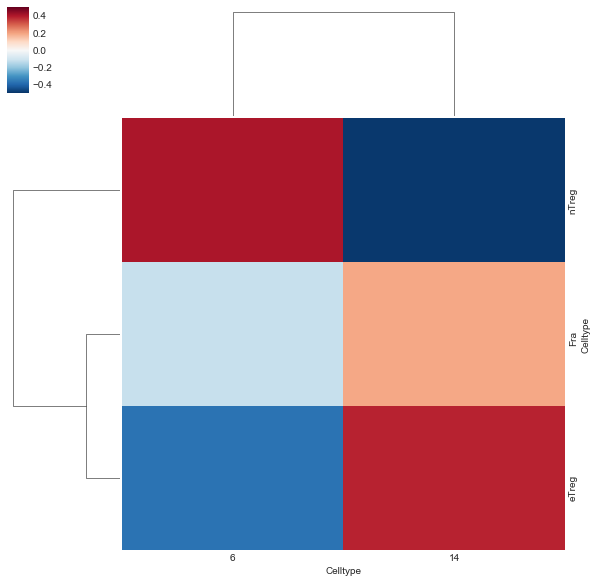

In [240]:
DiffGenes=list(ZsubGeneExpDF.index)

ZsubGeneExpDF.loc['Celltype']=[i.split('_')[0] for i in list(ZsubGeneExpDF)]
MeanZsubGeneExpDF=ZsubGeneExpDF.T.groupby('Celltype').apply(np.mean)
ZExpSeurat=ExpSeurat.apply(scipy.stats.zscore,axis=0).T
ZExpSeurat=ZExpSeurat.loc[DiffGenes].dropna()
ZExpSeurat.loc['State2']=MetaDF.loc[ZExpSeurat.columns]['State2']
ZExpSeurat.loc['Celltype']=MetaDF.loc[ZExpSeurat.columns]['Cluster']
ZExpSeuratMean=ZExpSeurat.T.groupby(['State2','Celltype']).apply(np.mean)
MeanZsubGeneExpDF=MeanZsubGeneExpDF.T.loc[list(ZExpSeuratMean)]

CombDF=pd.concat([pd.DataFrame(ZExpSeuratMean.T['N']),MeanZsubGeneExpDF],axis=1)
fig=sns.clustermap(CombDF.corr(method='pearson')[[6,14]].loc[['Fra','eTreg','nTreg']],cmap='RdBu_r',vmax=0.5,vmin=-0.5)                      
fig.savefig(os.path.join(Dir,'Seurat_NormTreg_subsets_TregCorrelations.pdf'))
plt.show()

CombDF=pd.concat([pd.DataFrame(ZExpSeuratMean.T['S']),MeanZsubGeneExpDF],axis=1)
fig=sns.clustermap(CombDF.corr(method='pearson')[[6,14]].loc[['Fra','eTreg','nTreg']],cmap='RdBu_r',vmax=0.5,vmin=-0.5)                      
fig.savefig(os.path.join(Dir,'Seurat_SLETreg_subsets_TregCorrelations.pdf'))
plt.show()



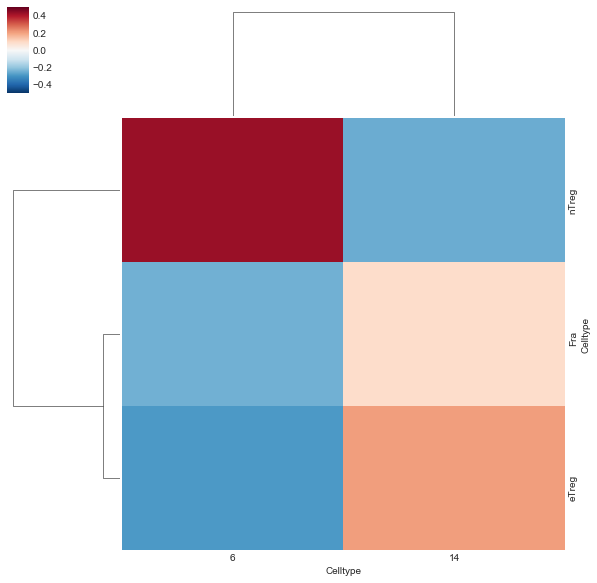

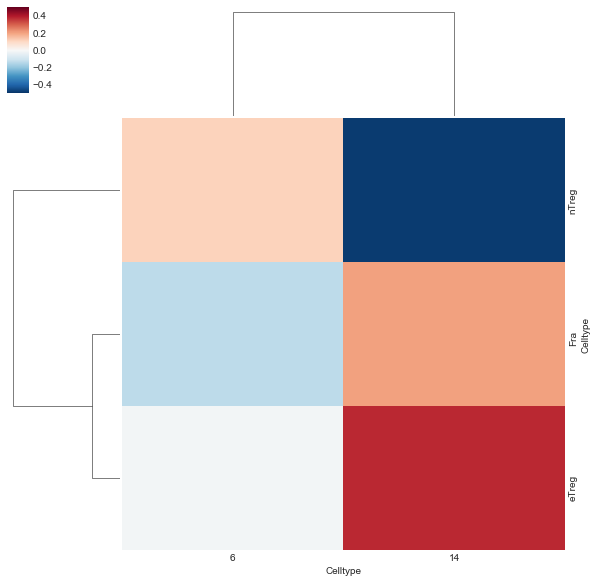

In [241]:

DiffGenes=list(ZsubGeneExpDF.index)

ZsubGeneExpDF.loc['Celltype']=[i.split('_')[0] for i in list(ZsubGeneExpDF)]
MeanZsubGeneExpDF=ZsubGeneExpDF.T.groupby('Celltype').apply(np.mean)
ZExpSaver=ExpSaver.apply(scipy.stats.zscore,axis=0).T
ZExpSaver=ZExpSaver.loc[DiffGenes].dropna()
ZExpSaver.loc['State2']=MetaDF.loc[ZExpSaver.columns]['State2']
ZExpSaver.loc['Celltype']=MetaDF.loc[ZExpSaver.columns]['Cluster']
ZExpSaverMean=ZExpSaver.T.groupby(['State2','Celltype']).apply(np.mean)
MeanZsubGeneExpDF=MeanZsubGeneExpDF.T.loc[list(ZExpSaverMean)]

CombDF=pd.concat([pd.DataFrame(ZExpSaverMean.T['N']),MeanZsubGeneExpDF],axis=1)
fig=sns.clustermap(CombDF.corr(method='pearson')[[6,14]].loc[['Fra','eTreg','nTreg']],cmap='RdBu_r',vmax=0.5,vmin=-0.5)                      
fig.savefig(os.path.join(Dir,'Saver_NormTreg_subsets_TregCorrelations.pdf'))
plt.show()

CombDF=pd.concat([pd.DataFrame(ZExpSaverMean.T['S']),MeanZsubGeneExpDF],axis=1)
fig=sns.clustermap(CombDF.corr(method='pearson')[[6,14]].loc[['Fra','eTreg','nTreg']],cmap='RdBu_r',vmax=0.5,vmin=-0.5)                      
fig.savefig(os.path.join(Dir,'Saver_SLETreg_subsets_TregCorrelations.pdf'))
plt.show()



In [308]:
SignatureDF=ReadTable(Signature)
SignatureDF['FraTreg']=FraTregSignature+[np.nan]*(1000-len(FraTregSignature))
SignatureDF['eTreg']=eTregSignature+[np.nan]*(1000-len(eTregSignature))
SignatureDF['nTreg']=nTregSignature+[np.nan]*(1000-len(nTregSignature))


# Signature Score

In [367]:
Dir=os.path.join(outDir,'Treg_Signature_Score')
Mkdir(Dir)


In [310]:
ExpSaver=ReadTable(SAVER)
ExpSeurat=ReadTable(DATA)


In [311]:
def Norm01(L):
    m=max(L)
    n=min(L)
    r=m-n
    return [(i-n)/float(r) for i in L]


SignatureScoreDF=pd.DataFrame({},index=ExpSaver.index)
SignatureScoreDF_MeanExp=pd.DataFrame({},index=ExpSaver.index)
for gs in SignatureDF.columns:
    #print gs
    N=len(SignatureDF[gs].dropna())
    try:
        Exp=list(ExpSaver.T.loc[list(SignatureDF[gs].dropna())].dropna().apply(sum,axis=0))
        SignatureScoreDF[gs]=Norm01(Exp)
        SignatureScoreDF_MeanExp[gs]=list(ExpSaver.T.loc[list(SignatureDF[gs].dropna())].dropna().apply(np.mean,axis=0))
    except KeyError:
        continue
    #SignatureScoreDF_MeanExp[gs]=[i/float(N) for i in Exp]


In [312]:
#Save signature Score
SaveTable(SignatureScoreDF, os.path.join(Dir,'Treg_Signature_Score.txt'))
SaveTable(SignatureScoreDF_MeanExp, os.path.join(Dir,'Treg_Signature_MeanExpression.txt'))



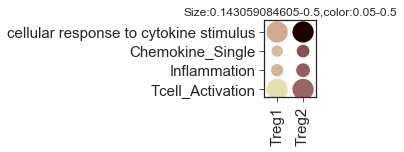

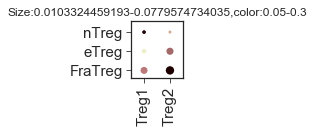

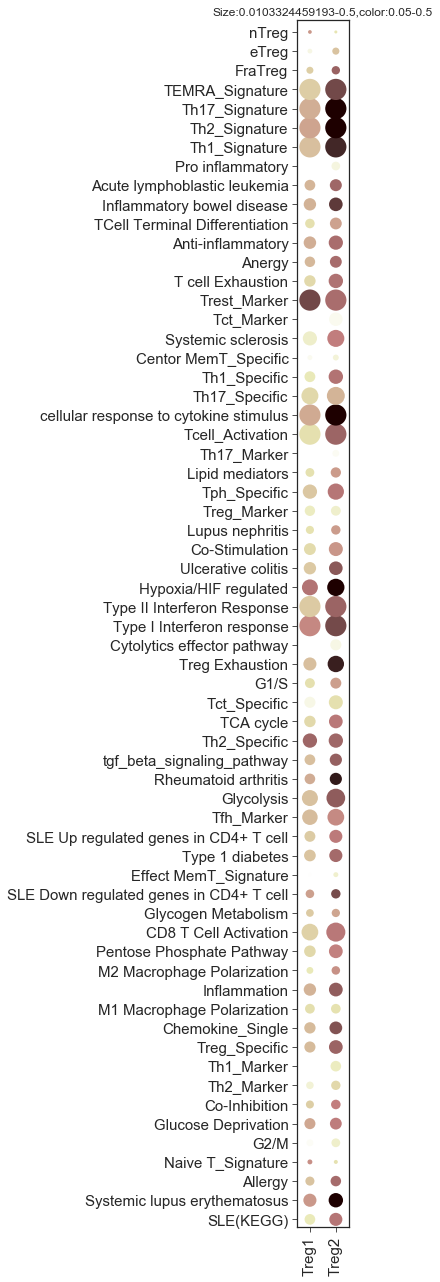

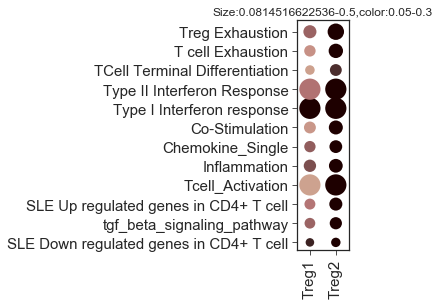

In [313]:
MeanSSs,_=GetDF_ColorSizeDF(SignatureScoreDF,0,[Treg6Cells,Treg14Cells],['Treg1','Treg2'])
MeanSExp,_=GetDF_ColorSizeDF(SignatureScoreDF_MeanExp,0,[Treg6Cells,Treg14Cells],['Treg1','Treg2'])


GS1=['Tcell_Activation','Inflammation','Chemokine_Single','cellular response to cytokine stimulus']
GS2=['FraTreg','eTreg','nTreg']
GS3=['SLE Up regulated genes in CD4+ T cell','Type I Interferon response','SLE Down regulated genes in CD4+ T cell']                                        
GS4=['Treg Exhaustion','T cell Exhaustion']
GS5=['SLE Down regulated genes in CD4+ T cell','tgf_beta_signaling_pathway','SLE Up regulated genes in CD4+ T cell','Tcell_Activation','Inflammation','Chemokine_Single','Co-Stimulation','Type I Interferon response','Type II Interferon Response','TCell Terminal Differentiation','T cell Exhaustion','Treg Exhaustion']                         



CircularPlot(MeanSSs.loc[GS1],MeanSExp.loc[GS1],'CellActivation.SignatureScore.Expression.Saver',Dir,vmin=0.05,vmax=0.5,sizevmax=0.5,sizeWeight=900,cmap='pink_r')
CircularPlot(MeanSSs.loc[GS2],MeanSExp.loc[GS2],'TregSubtype.SignatureScore.Expression.Saver',Dir,vmin=0.05,vmax=0.3,sizevmax=0.5,sizeWeight=900,cmap='pink_r')
CircularPlot(MeanSSs,MeanSExp,'AllSignatureScore.Expression.Saver',Dir,vmin=0.05,vmax=0.5,sizevmax=0.5,sizeWeight=900,cmap='pink_r')
CircularPlot(MeanSSs.loc[GS5],MeanSExp.loc[GS5],'SLEAssociated.SignatureScore.Expression.Saver',Dir,vmin=0.05,vmax=0.3,sizevmax=0.5,sizeWeight=900,cmap='pink_r')




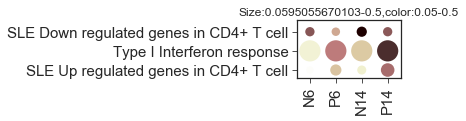

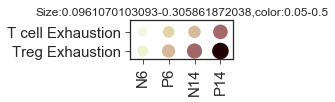

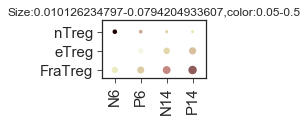

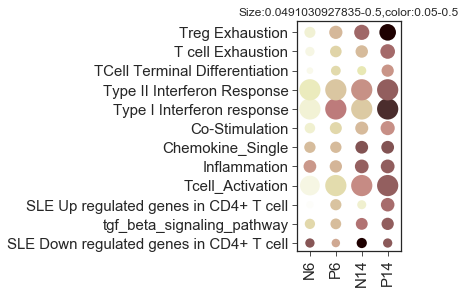

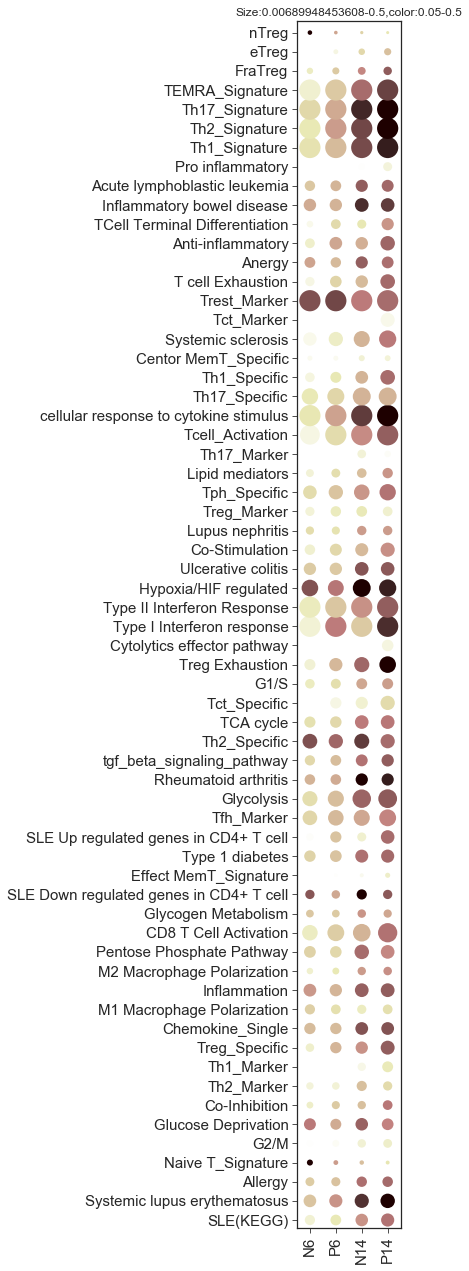

In [314]:
MeanSSs,_=GetDF_ColorSizeDF(SignatureScoreDF,0,[N6Cells,P6Cells,N14Cells,P14Cells],['N6','P6','N14','P14'])
MeanSExp,_=GetDF_ColorSizeDF(SignatureScoreDF_MeanExp,0,[N6Cells,P6Cells,N14Cells,P14Cells],['N6','P6','N14','P14'])



CircularPlot(MeanSSs.loc[GS3],MeanSExp.loc[GS3],'CellActivation.SignatureScore.Expression.Saver.NormSLEDiff',Dir,vmin=0.05,vmax=0.5,sizevmax=0.5,sizeWeight=900,cmap='pink_r')
CircularPlot(MeanSSs.loc[GS4],MeanSExp.loc[GS4],'TregExhaustion.SignatureScore.Expression.Saver.NormSLEDiff',Dir,vmin=0.05,vmax=0.5,sizevmax=0.5,sizeWeight=900,cmap='pink_r')
CircularPlot(MeanSSs.loc[GS2],MeanSExp.loc[GS2],'TregSubtype.SignatureScore.Expression.Saver.NormSLEDiff',Dir,vmin=0.05,vmax=0.5,sizevmax=0.5,sizeWeight=900,cmap='pink_r')
CircularPlot(MeanSSs.loc[GS5],MeanSExp.loc[GS5],'SLEAssociated.SignatureScore.Expression.Saver.NormSLEDiff',Dir,vmin=0.05,vmax=0.5,sizevmax=0.5,sizeWeight=900,cmap='pink_r')


CircularPlot(MeanSSs,MeanSExp,'AllSignatureScore.Expression.Saver.NormSLEDiff',Dir,vmin=0.05,vmax=0.5,sizevmax=0.5,sizeWeight=900,cmap='pink_r')



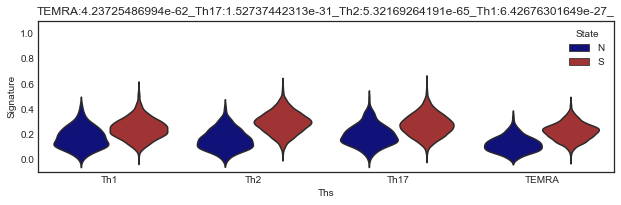

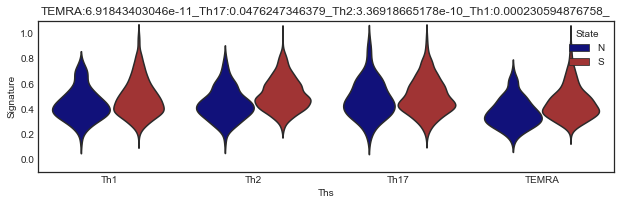

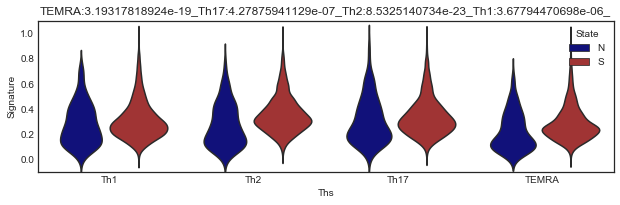

In [315]:
N=len(SignatureScoreDF)
SignatureScore=list(SignatureScoreDF['Th1_Signature'])+list(SignatureScoreDF['Th2_Signature'])+list(SignatureScoreDF['Th17_Signature'])+list(SignatureScoreDF['TEMRA_Signature'])                                                                                       
Ths=['Th1']*N+['Th2']*N+['Th17']*N+['TEMRA']*N
States=list(MetaDF.loc[SignatureScoreDF.index]['State2'])*4
Subtypes=list(MetaDF.loc[SignatureScoreDF.index]['Cluster'])*4
DF=pd.DataFrame({'Signature':SignatureScore,'Ths':Ths,'State':States,'Subtypes':Subtypes})

DF_Treg1=DF[DF['Subtypes']==6]
DF_Treg2=DF[DF['Subtypes']==14]
    
def ViolinPlot(DF,label, x,y,hue='State',hueDict={'N':'darkblue','S':'firebrick'}):
    Title=''
    for i in list(set(DF[x])):
        df=DF[DF[x]==i]
        A=df[df[hue]=='N'][y]
        B=df[df[hue]=='S'][y]
        Title=Title+i+':'+str(scipy.stats.mannwhitneyu(A.values,B.values)[1])+'_'
    
    fig=plt.figure(figsize=(10,3))
    #ax=fig.add_axes([10.0/(10+0.45*len(list(DF))),0.2,0.95-10.0/(10+0.45*len(list(DF))),0.7])
    ax=fig.add_axes([0.2,0.2,0.8,0.7])
    sns.violinplot(x=x, y=y, hue=hue,data=DF, palette=hueDict,split=False,  inner=None,ax=ax) 
    ax.set_title(Title)
    ax.set_ylim(-0.1,1.1)
    plt.savefig(os.path.join(Dir, label+'.pdf'))
    plt.show()
        
ViolinPlot(DF_Treg1,'Treg1.ThLike_Signature','Ths','Signature',hue='State',hueDict={'N':'darkblue','S':'firebrick'})
ViolinPlot(DF_Treg2,'Treg2.ThLike_Signature','Ths','Signature',hue='State',hueDict={'N':'darkblue','S':'firebrick'})
ViolinPlot(DF,'Treg.ThLike_Signature','Ths','Signature',hue='State',hueDict={'N':'darkblue','S':'firebrick'})
          
    

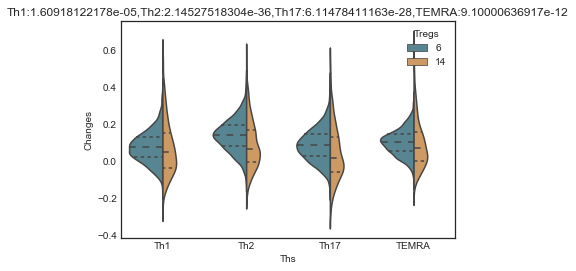

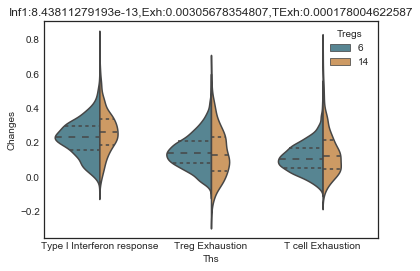

In [316]:
#Th like 
Norm6_Cells=list(MetaDF[(MetaDF['Cluster']==6)&(MetaDF['State2']=='N')].index)
SLE6_Cells=list(MetaDF[(MetaDF['Cluster']==6)&(MetaDF['State2']=='S')].index)
Norm14_Cells=list(MetaDF[(MetaDF['Cluster']==14)&(MetaDF['State2']=='N')].index)
SLE14_Cells=list(MetaDF[(MetaDF['Cluster']==14)&(MetaDF['State2']=='S')].index)

Norm6_Base=SignatureScoreDF.loc[Norm6_Cells].apply(np.median,axis=0)
Norm14_Base=SignatureScoreDF.loc[Norm14_Cells].apply(np.median,axis=0)



SLE6_Changes_DF=pd.DataFrame({},index=SLE6_Cells)
SLE14_Changes_DF=pd.DataFrame({},index=SLE14_Cells)

for gs in ['Th1_Signature','Th2_Signature','Th17_Signature','TEMRA_Signature','Type I Interferon response','Treg Exhaustion','T cell Exhaustion']:
    SLE6_Changes_DF[gs]=SignatureScoreDF.loc[SLE6_Cells][gs]-Norm6_Base[gs]
    SLE14_Changes_DF[gs]=SignatureScoreDF.loc[SLE14_Cells][gs]-Norm14_Base[gs]
    

###Th-like Transition
N6=len(SLE6_Changes_DF)
N14=len(SLE14_Changes_DF)
Changes=list(SLE6_Changes_DF['Th1_Signature'])+list(SLE6_Changes_DF['Th2_Signature'])+list(SLE6_Changes_DF['Th17_Signature'])+list(SLE6_Changes_DF['TEMRA_Signature'])+list(SLE14_Changes_DF['Th1_Signature'])+list(SLE14_Changes_DF['Th2_Signature'])+list(SLE14_Changes_DF['Th17_Signature'])+list(SLE14_Changes_DF['TEMRA_Signature'])                                                                                       
Ths=['Th1']*N6+['Th2']*N6+['Th17']*N6+['TEMRA']*N6+['Th1']*N14+['Th2']*N14+['Th17']*N14+['TEMRA']*N14
Tregs=[6]*N6*4+[14]*N14*4
DF=pd.DataFrame({'Changes':Changes,'Ths':Ths,'Tregs':Tregs})
  
    
Th1_P,Th2_P,Th17_P,TEMRA_P= scipy.stats.mannwhitneyu(SLE6_Changes_DF['Th1_Signature'],SLE14_Changes_DF['Th1_Signature'])[1],scipy.stats.mannwhitneyu(SLE6_Changes_DF['Th2_Signature'],SLE14_Changes_DF['Th2_Signature'])[1],scipy.stats.mannwhitneyu(SLE6_Changes_DF['Th17_Signature'],SLE14_Changes_DF['Th17_Signature'])[1],scipy.stats.mannwhitneyu(SLE6_Changes_DF['TEMRA_Signature'],SLE14_Changes_DF['TEMRA_Signature'])[1]   
    
sns.violinplot(x="Ths", y="Changes", hue="Tregs",data=DF, palette=ClusterColorDict, split=True, scale="count", inner="quartile") 
plt.title('Th1:{},Th2:{},Th17:{},TEMRA:{}'.format(str(Th1_P),str(Th2_P),str(Th17_P),str(TEMRA_P)))
plt.savefig(os.path.join(Dir, 'Th-like_Transition_Potential.pdf'))
plt.show()



###Exhaustion Transition
Changes=list(SLE6_Changes_DF['Type I Interferon response'])+list(SLE6_Changes_DF['Treg Exhaustion'])+list(SLE6_Changes_DF['T cell Exhaustion'])+list(SLE14_Changes_DF['Type I Interferon response'])+list(SLE14_Changes_DF['Treg Exhaustion'])+list(SLE14_Changes_DF['T cell Exhaustion'])                                                                                   
Ths=['Type I Interferon response']*N6+['Treg Exhaustion']*N6+['T cell Exhaustion']*N6+['Type I Interferon response']*N14+['Treg Exhaustion']*N14+['T cell Exhaustion']*N14
Tregs=[6]*N6*3+[14]*N14*3
DF=pd.DataFrame({'Changes':Changes,'Ths':Ths,'Tregs':Tregs})
  
    
Inf1_P,Exh_P,TExh_P= scipy.stats.mannwhitneyu(SLE6_Changes_DF['Type I Interferon response'],SLE14_Changes_DF['Type I Interferon response'])[1],scipy.stats.mannwhitneyu(SLE6_Changes_DF['Treg Exhaustion'],SLE14_Changes_DF['Treg Exhaustion'])[1],scipy.stats.mannwhitneyu(SLE6_Changes_DF['T cell Exhaustion'],SLE14_Changes_DF['T cell Exhaustion'])[1]   
    
sns.violinplot(x="Ths", y="Changes", hue="Tregs",data=DF, palette=ClusterColorDict, split=True, scale="count", inner="quartile") 
plt.title('Inf1:{},Exh:{},TExh:{}'.format(str(Inf1_P),str(Exh_P),str(TExh_P)))
plt.savefig(os.path.join(Dir, 'Exhaustion_Potential.pdf'))
plt.show()



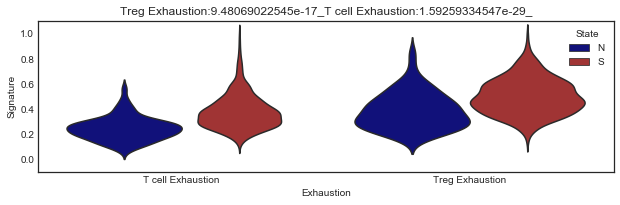

In [317]:
N=len(SignatureScoreDF)
SignatureScore=list(SignatureScoreDF['T cell Exhaustion'])+list(SignatureScoreDF['Treg Exhaustion'])                                                                                    
Exhaustion=['T cell Exhaustion']*N+['Treg Exhaustion']*N
States=list(MetaDF.loc[SignatureScoreDF.index]['State2'])*2
Subtypes=list(MetaDF.loc[SignatureScoreDF.index]['Cluster'])*2
DF=pd.DataFrame({'Signature':SignatureScore,'Exhaustion':Exhaustion,'State':States,'Subtypes':Subtypes})

DF_Treg2=DF[DF['Subtypes']==14]
    
ViolinPlot(DF_Treg2,'Treg2.Exhaustion_Signature','Exhaustion','Signature',hue='State',hueDict={'N':'darkblue','S':'firebrick'})


    
    

# Treg exhaustion correlated genes 

In [368]:
CellOrder=SignatureScoreDF['Treg Exhaustion'].sort_values().index


In [369]:
#Remove low expressed Genes
ExpSaver=ExpSaver.T
ExpSaver_2=ExpSaver[(ExpSaver>0.005).apply(sum,axis=1)>1000]
ExpSaver_2=ExpSaver_2[ExpSaver_2.apply(max,axis=1)>1]


In [370]:

CorDF=pd.DataFrame({},index=ExpSaver_2.index)
Cor=[]
for i in ExpSaver_2.index:
    Cor.append(scipy.stats.pearsonr(SignatureScoreDF['Treg Exhaustion'],ExpSaver.T.loc[SignatureScoreDF.index][i] )[0] )            
CorDF['Treg_Exhaustion']=Cor
    
    

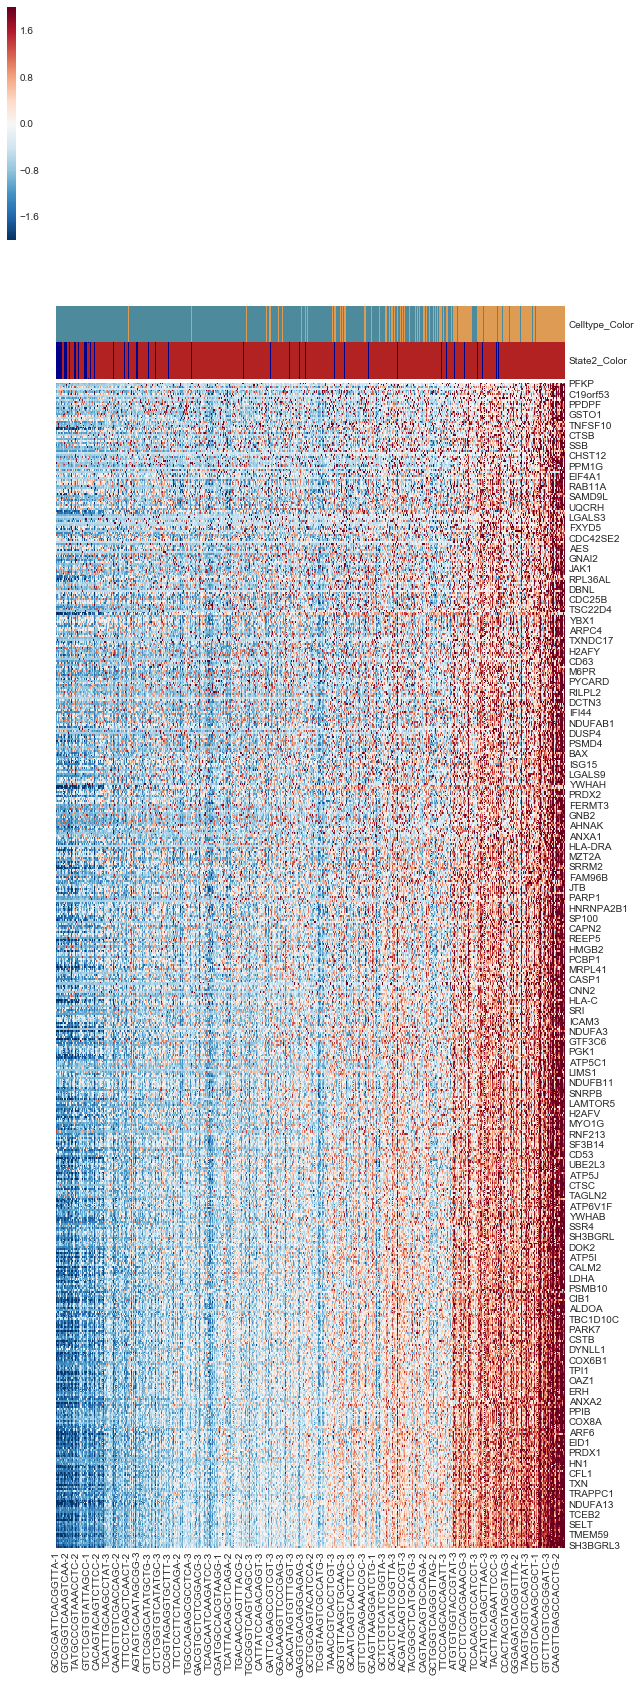

In [374]:
AllCorGenes=[i for i in list(CorDF[CorDF['Treg_Exhaustion']>0.4].sort_values('Treg_Exhaustion').index) if i not in list(SignatureDF['Treg Exhaustion'].dropna())]                                                                                               
Zsort_Cor_GeneExp=ExpSaver[CellOrder].loc[AllCorGenes].apply(scipy.stats.zscore,axis=1)


fig=sns.clustermap(Zsort_Cor_GeneExp,figsize=(10,0.05*len(Zsort_Cor_GeneExp)),col_cluster=False,row_cluster=False,vmax=2,vmin=-2,cmap='RdBu_r', col_colors=MetaDF.loc[Zsort_Cor_GeneExp.columns][['Celltype_Color','State2_Color']])                
fig.savefig(os.path.join(Dir,'ExhaustionOrder.CorrelatedGenes.Heatmap.pdf'))
plt.show()
    
SaveTable(Zsort_Cor_GeneExp,os.path.join(Dir,'ExhaustionOrder.CorrelatedGenes.Heatmap.txt'))


